In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import pandas as pd
import numpy as np

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split

import multiprocessing

from data_augmentaion.data_augmentator import DataAugmentor 

import json

import time

### Define research parameters

In [44]:
regression_task = True
continuous_features=['AGE', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6'] # not ['SEX']
metrics = ['neg_root_mean_squared_error', 'r2']
test_size_proportion = 0.2
augment_sample = 0.5

search_pipelines = pipelines.get_regression_pipelines()
search_parameters = models.regression_parameters

settings = [
    {'method': 'random'},
    {'method': 'smote'},
    {'method': 'cf_random'},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 1}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}},
]

### Read and preprocess data

In [45]:
df = pd.read_csv(r'../datasets/diabetes.txt', sep='\t')
target = 'Y'

#### split data

In [46]:
# all data
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)
df_train = pd.concat([X_train, y_train], axis=1)

<AxesSubplot:>

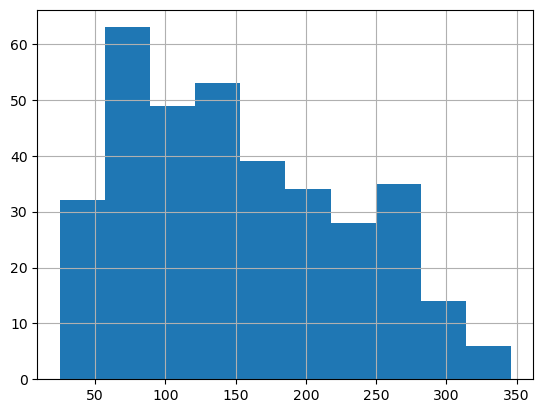

In [47]:
y_train.hist()

In [48]:
full_results_df = pd.DataFrame()

### Whole dataset scores

without augmentation scores:


whole          
      neg_root_mean_squared_error        r2
lr                     -53.853446  0.452603
ridge                  -53.842869  0.453519
lasso                  -53.774196  0.454213
rf                     -53.762652  0.454447
xgb                    -53.924630  0.451155

<AxesSubplot:>

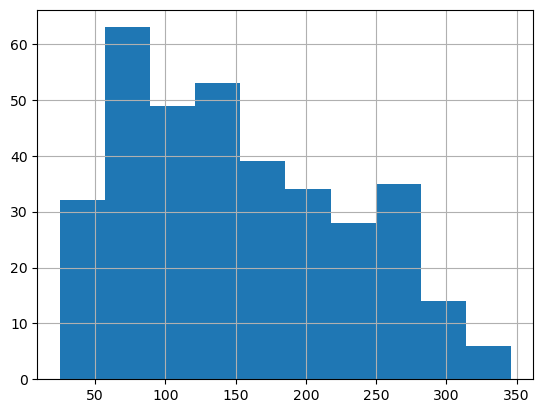

In [49]:
print(f'without augmentation scores:')
whole_best_ests, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
display(whole_dataset_result_df)
y_train.hist()

In [50]:
full_results_df = pd.concat([full_results_df, whole_dataset_result_df], axis=1)

### running experiments

In [51]:
best_estimators = {}
best_scores = {}
total_time = time.time()
for i, s in enumerate(settings):
    start = time.time()
    print(f'{i+1} / {len(settings)}, {s}', end=' ')
    augmentor = DataAugmentor(X_train, y_train, X_test, y_test,
                             method=s['method'], regression=regression_task,
                             continuous_feats=continuous_features,
                             kw_args=s.get('kw_args', {})
                             )
    if s['method'][:2] != 'cf':
        X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
        best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
        utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
        result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'], orient='index')
        result_df_balanced.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])} balanced']] + [result_df_balanced.columns])
        # result_df_balanced.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))} balanced']] + [result_df_balanced.columns])


    X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
    best_estimators[f'{i}'], best_scores[f'{i}'] = \
        utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df = pd.DataFrame.from_dict(best_scores[f'{i}'], orient='index')
    result_df.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])}']] + [result_df.columns])
    # result_df.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))}']] + [result_df.columns])
    

    full_results_df = pd.concat([full_results_df, result_df_balanced, result_df], axis=1)
    print(f'{time.time() - start} seconds for settings {i}')

print(f'\nTotal time: {time.time() - total_time}')

1 / 4, {'method': 'random'} 21.536718606948853 seconds for settings 0
2 / 4, {'method': 'smote'} 21.132439136505127 seconds for settings 1
3 / 4, {'method': 'cf_random'} model for cf neg_root_mean_squared_error score: {'cf': {'neg_root_mean_squared_error': -53.59294397603038}}
0/176


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


50/176


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


100/176


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


150/176


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


54.31402850151062 seconds for settings 2
4 / 4, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}} model for cf neg_root_mean_squared_error score: {'cf': {'neg_root_mean_squared_error': -53.59294397603038}}
0/176


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


50/176


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


100/176


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


150/176


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


49.68143558502197 seconds for settings 3

Total time: 146.66462182998657


### results

In [68]:
full_results_df = full_results_df.T.drop_duplicates().T
full_results_df

whole                       random balanced  \
      neg_root_mean_squared_error        r2 neg_root_mean_squared_error   
lr                     -53.853446  0.452603                  -54.407337   
ridge                  -53.842869  0.453519                  -54.398790   
lasso                  -53.774196  0.454213                  -54.308541   
rf                     -53.762652  0.454447                  -53.811878   
xgb                    -53.924630  0.451155                  -54.198043   

                                     random            \
             r2 neg_root_mean_squared_error        r2   
lr     0.441285                  -54.329898  0.442874   
ridge  0.441460                  -54.305594  0.443372   
lasso  0.443312                  -54.266014  0.444183   
rf     0.453447                  -52.980496  0.470205   
xgb    0.445575                  -63.883239  0.254359   

                   smote balanced                                 smote  \
      neg_root_mean_squared_error        r2 neg_root_mean_squared_error   
lr                     -54.042278  0.448757                  -54.651279   
ridge                  -54.034443  0.448917                  -54.644648   
lasso                  -53.948500  0.450669                  -54.553050   
rf                     -53.179822  0.466211                  -54.530393   
xgb                    -57.079989  0.385045                  -54.383498   

                                  cf_random            \
             r2 neg_root_mean_squared_error        r2   
lr     0.436263                  -53.449001  0.460794   
ridge  0.436400                  -53.443422  0.460906   
lasso  0.438288                  -52.771352  0.474380   
rf     0.438755                  -53.201920  0.465768   
xgb    0.441774                  -52.980514  0.484288   

                       cf_genetic            
      neg_root_mean_squared_error        r2  
lr                     -54.148440  0.446589  
ridge                  -54.133437  0.446896  
lasso                  -53.740643  0.454894  
rf                     -54.397829  0.441480  
xgb                    -52.409159  0.473175

In [69]:
# print('best methods')
# best_methods = pd.DataFrame()
# for s in metrics:
#     models_scores = full_results_df.xs(s, axis='columns', level=1)
#     if s.split('_')[-1] == 'error':
#         greater_models = models_scores.idxmin(axis='columns') 
#         greater_models['overall'] = models_scores.min(axis=0).idxmin(axis=0)
#     else:
#         greater_models = models_scores.idxmax(axis='columns')
#         greater_models['overall'] = models_scores.max(axis=0).idxmax(axis=0)

#     greater_models.name = s
#     best_methods = pd.concat([best_methods, greater_models], axis=1)
# best_methods

print('best methods')
best_methods = pd.DataFrame()
for s in metrics:
    models_scores = full_results_df.xs(s, axis='columns', level=1)
    max_models = models_scores.idxmax(axis='columns')
    max_models.name = s
    max_models['overall'] = models_scores.max(axis=0).idxmax(axis=0)
    best_methods = pd.concat([best_methods, max_models], axis=1)
best_methods

best methods


,neg_root_mean_squared_error,r2
lr,cf_random,cf_random
ridge,cf_random,cf_random
lasso,cf_random,cf_random
rf,random,random
xgb,cf_genetic,cf_random
overall,cf_genetic,cf_random


In [70]:
full_results_df.to_csv(rf'../log/experiment_regression_testsize{test_size_proportion}_augmentsample{augment_sample}.csv')

In [71]:
print('Methods and their scores')
methods_scores = {}
for s in metrics:
    models_scores = full_results_df.xs(s, axis='columns', level=1)
    methods_scores[s] = models_scores

Methods and their scores


In [72]:
float_format = "{:0.4f}".format
for metric, df in methods_scores.items():
    latex = df.style.format("{:.4f}").to_latex()

    # Write the LaTeX table to a file
    with open(f'../graphs/regression_{metric}_table.tex', 'w') as f:
        f.write(latex)

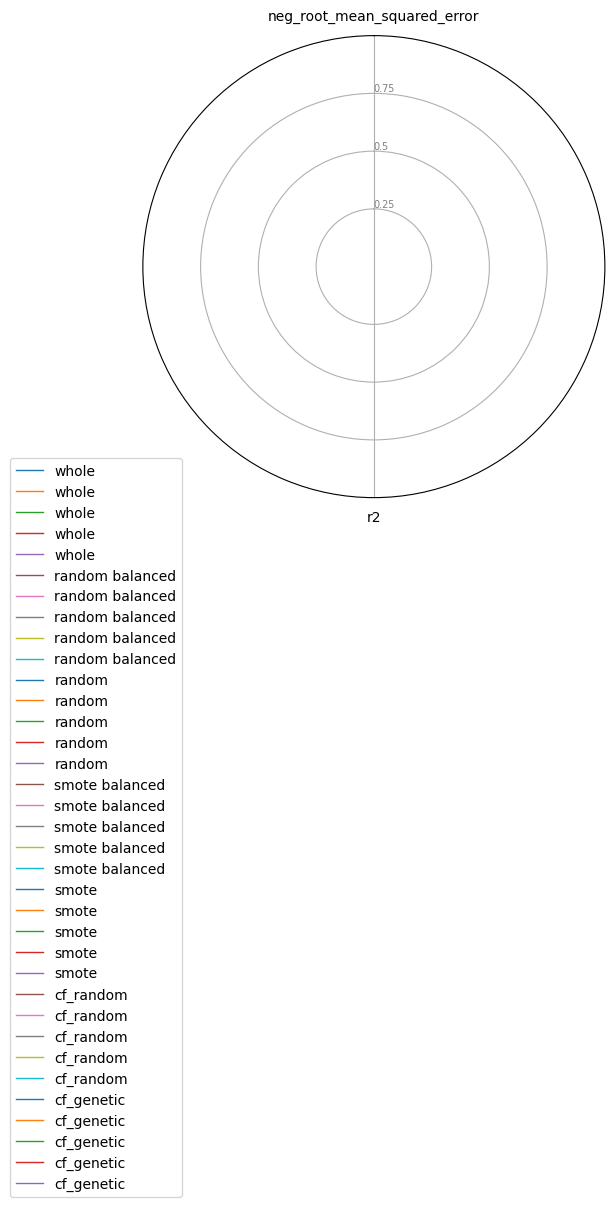

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Get the list of models
models = list(next(iter(methods_scores.values())).index)
# Number of variables (i.e., number of metrics)
num_vars = len(methods_scores)

# Compute angle of each axis in the plot (divide the plot / number of variable)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Ensure the plot is a full circle
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# If you want the first axis to be on top:
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], list(methods_scores.keys()))

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=7)
plt.ylim(0, 1)

# Plot data
for model in df.columns:
    values = [df[model] for df in methods_scores.values()]
    values += values[:1]  # repeat the first value to close the circular graph
    # print(values[0]["lg"])
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=model)
    ax.fill(angles, values, 'b', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()